In [1]:
import pandas as pd
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

#import albumentations as A
#from albumentations.pytorch import ToTensorV2

import cv2

from tqdm import tqdm
from PIL import Image

%matplotlib inline

# Split sets exploration

In [2]:
database1_source = ['global-bird-zenodo_poland', 'global-bird-zenodo_palmyra', 'global-bird-zenodo_penguins',
                    'global-bird-zenodo_mckellar', 'global-bird-zenodo_newmexico', 
                    'global-bird-zenodo_pfeifer'] #, 'uav-waterfowl-thermal']

database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/baseline1'

with open(os.path.join(database_folder, 'data_stats.yaml'), "r") as yamlfile:
    stats = yaml.load(yamlfile, Loader=yaml.FullLoader)

nb of backgruond img in split:  304


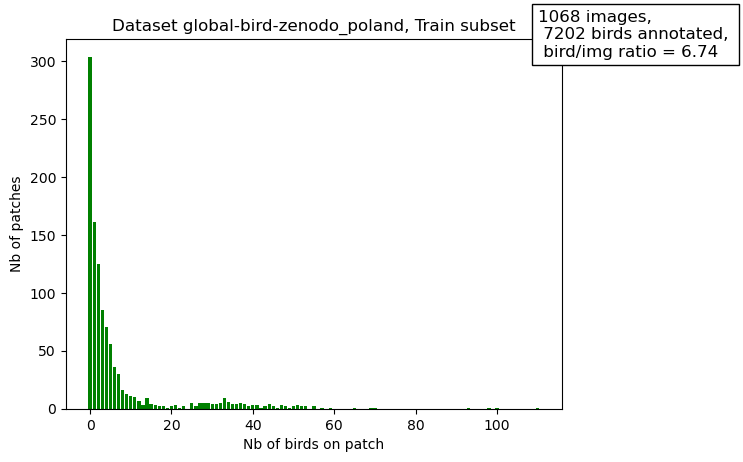

nb of backgruond img in split:  55


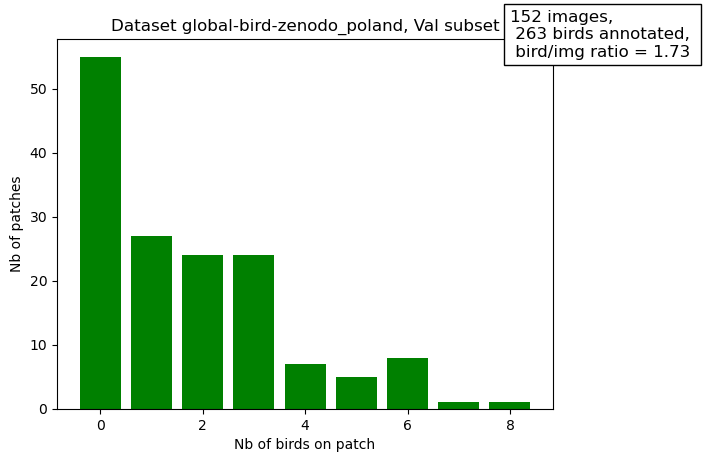

nb of backgruond img in split:  86


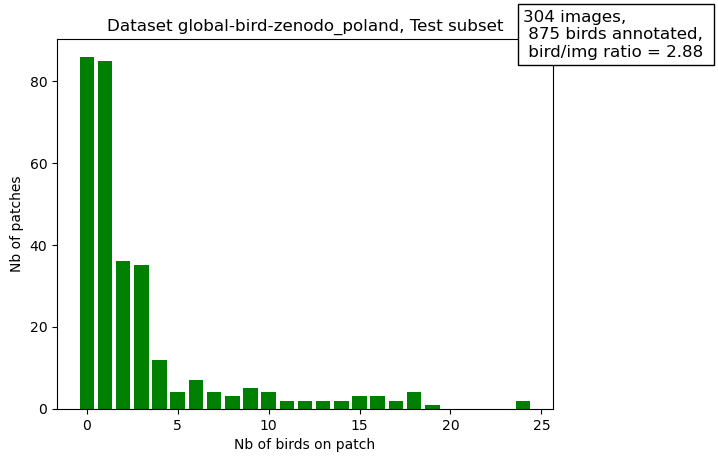

nb of backgruond img in split:  1551


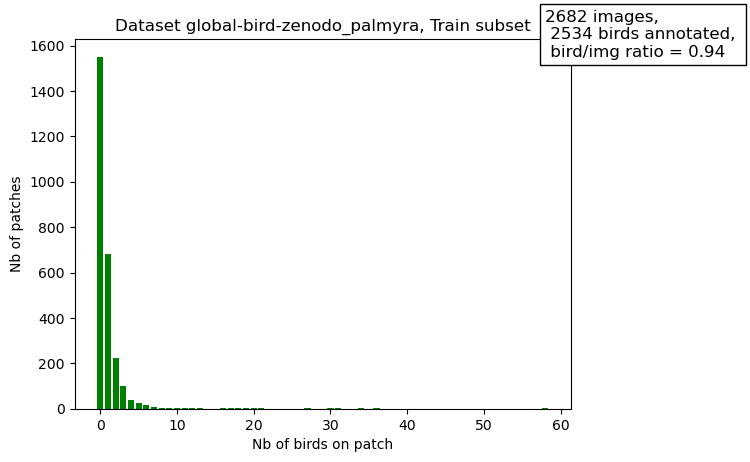

nb of backgruond img in split:  293


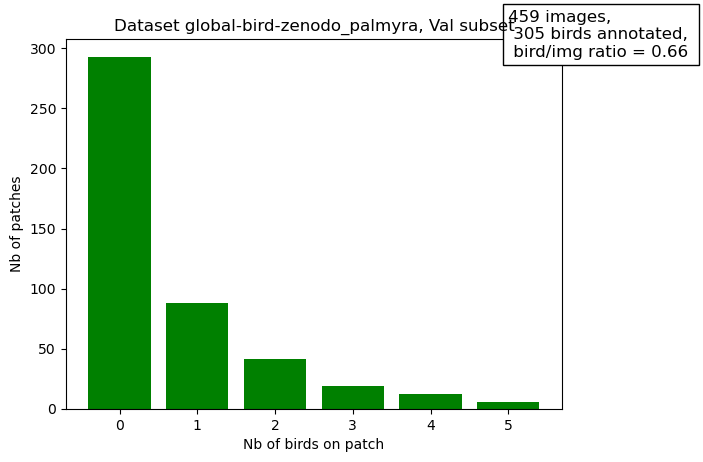

nb of backgruond img in split:  617


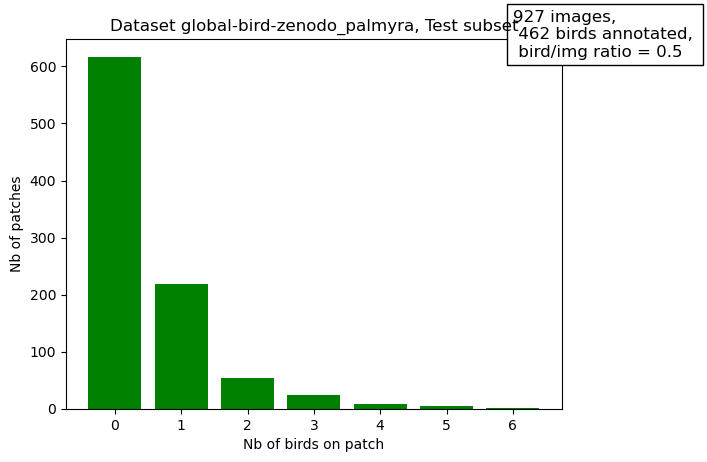

nb of backgruond img in split:  47


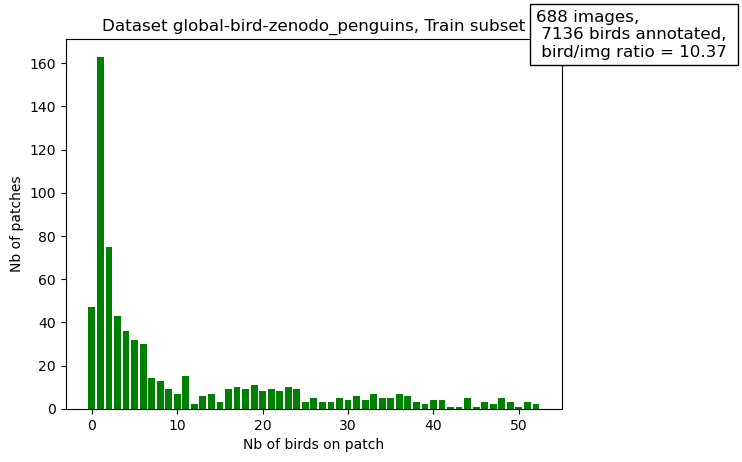

nb of backgruond img in split:  2


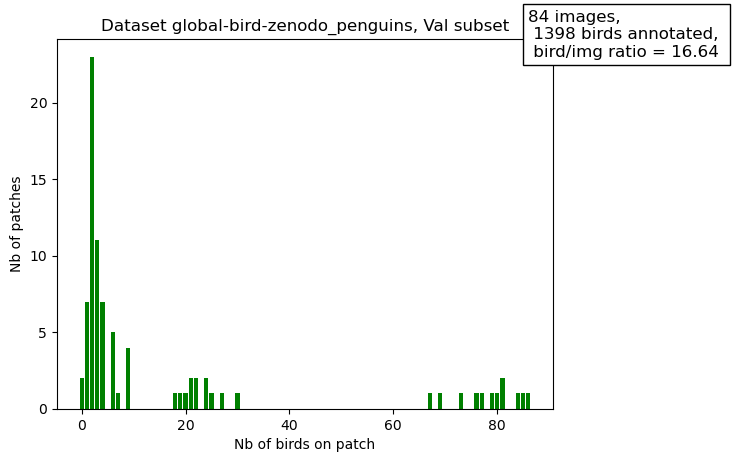

nb of backgruond img in split:  12


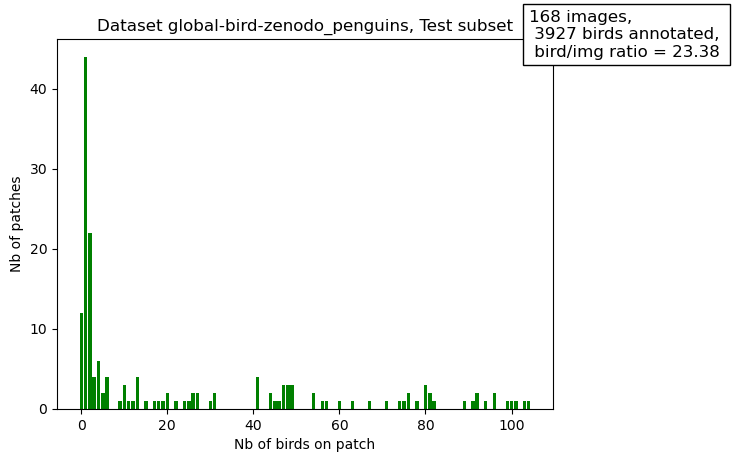

nb of backgruond img in split:  314


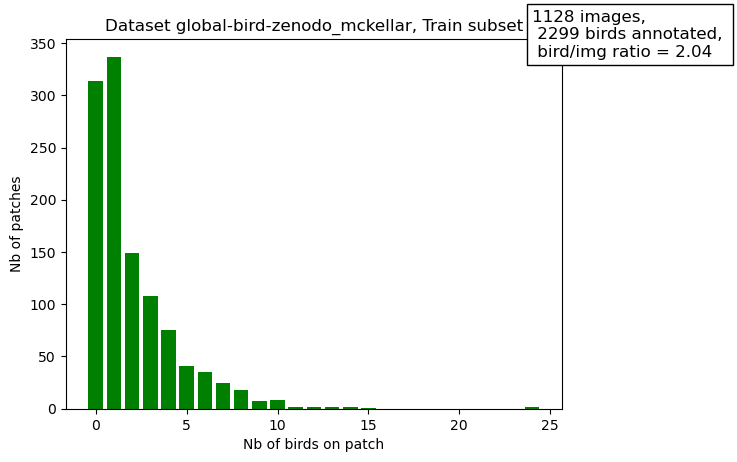

nb of backgruond img in split:  102


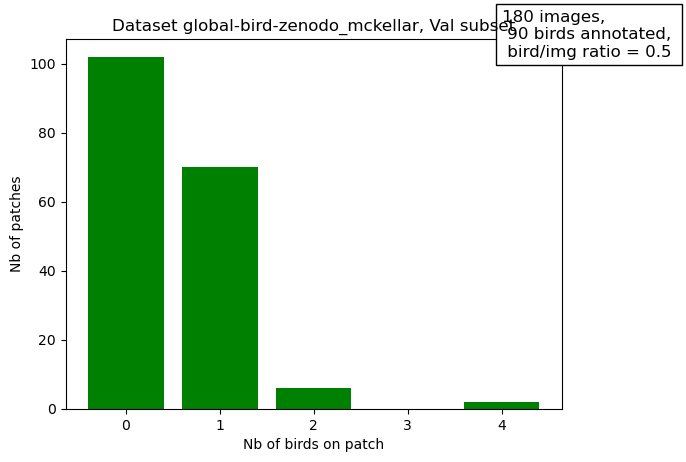

nb of backgruond img in split:  63


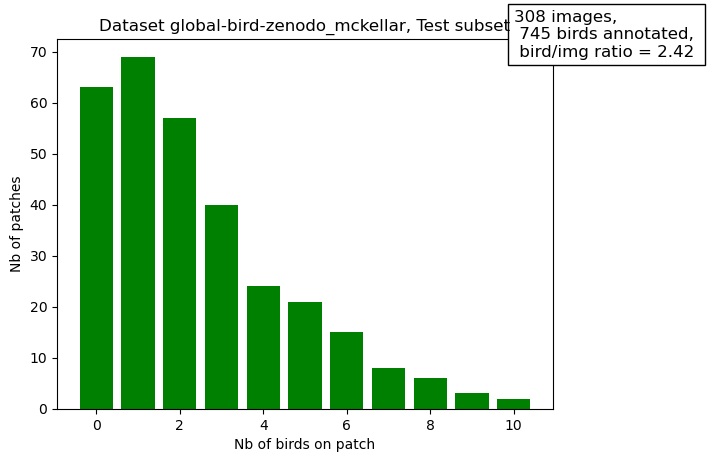

nb of backgruond img in split:  142


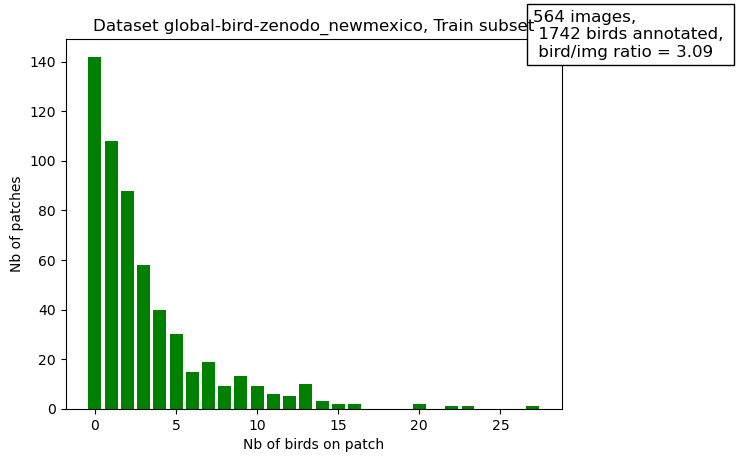

nb of backgruond img in split:  23


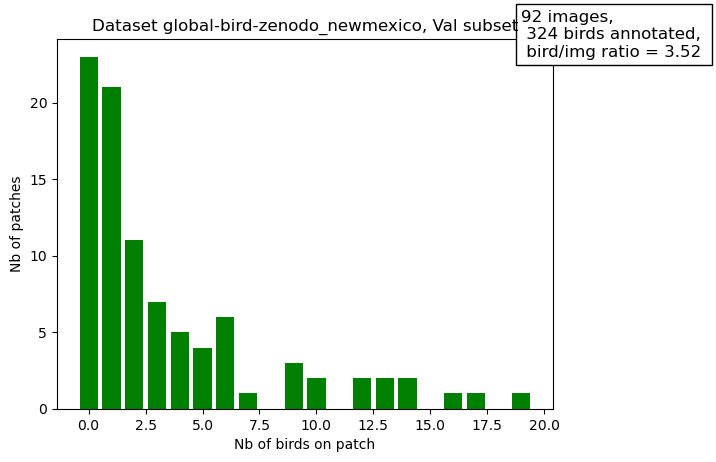

nb of backgruond img in split:  32


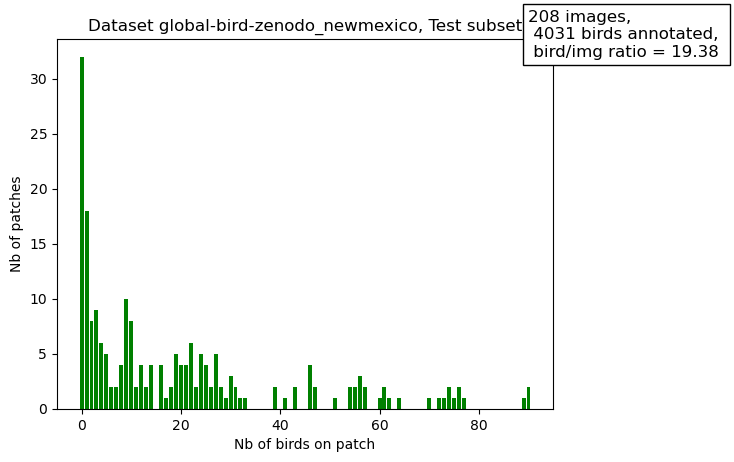

nb of backgruond img in split:  27


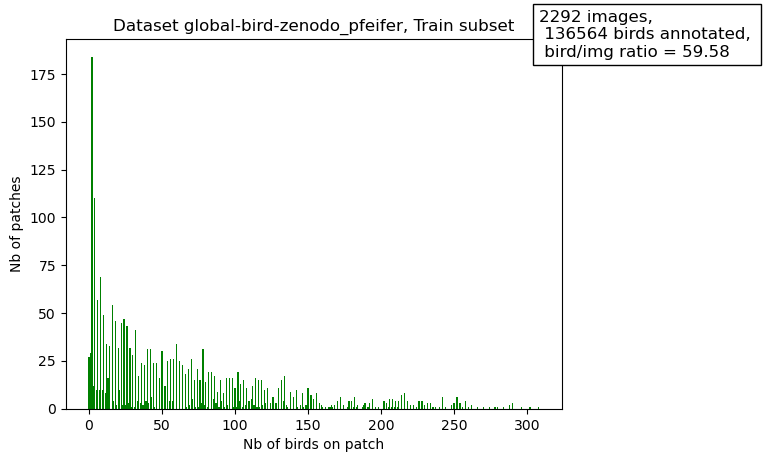

nb of backgruond img in split:  2


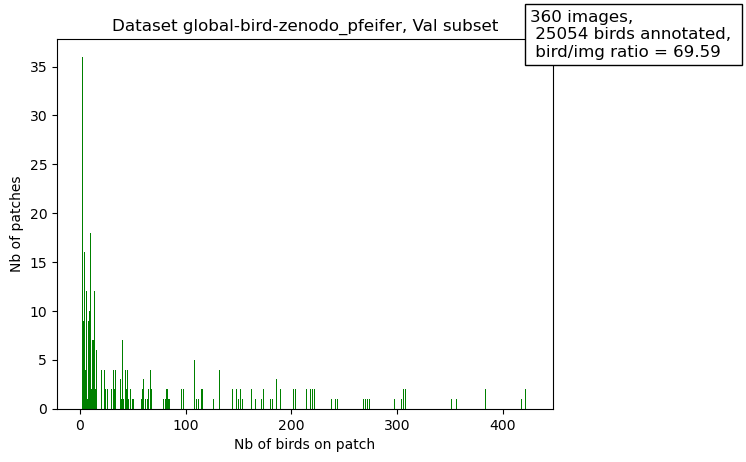

nb of backgruond img in split:  12


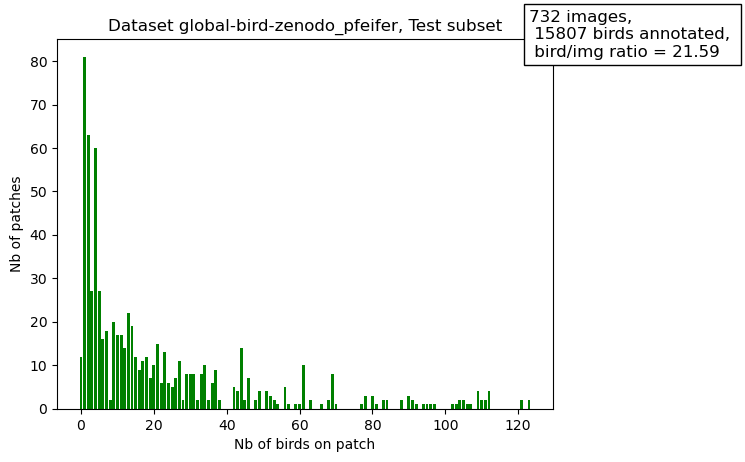

Nb of background images:  3684
Total nb of images:  12396


In [7]:
total_nb_bckgd_img = 0 
total_nb_img = 0 

for dataset in database1_source:

    dataset_stats = stats[dataset]

    for split in ['Train', 'Val', 'Test']:
        birds_repartition = dataset_stats[split]['birds_repartition']
        nb_birds = dataset_stats[split]['nb_birds']
        nb_img =dataset_stats[split]['nb_img']
        nb_background_img = nb_img - sum(birds_repartition.values())
        print("nb of backgruond img in split: ", nb_background_img)
        total_nb_bckgd_img += nb_background_img
        total_nb_img += nb_img
        birds_repartition[0] = nb_background_img
        bird_img_ratio = nb_birds/nb_img

        plt.bar(list(birds_repartition.keys()), birds_repartition.values(), color='g')
        plt.title(f'Dataset {dataset}, {split} subset')
        plt.text(max(birds_repartition.keys()), max(birds_repartition.values()), f"{nb_img} images, \n {nb_birds} birds annotated, \n bird/img ratio = {str(round(bird_img_ratio, 2))} ", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
        plt.xlabel('Nb of birds on patch')
        plt.ylabel('Nb of patches')
        plt.show()
        #plt.savefig(os.path.join(exploration_folder, f"stat_{dataset}_split_{split}.png"))

print("Nb of background images: ", total_nb_bckgd_img)
print("Total nb of images: ", total_nb_img)

## **Datasets means & standard deviations computation**

In [13]:
##### PARAMS
device      = torch.device('cpu') 
num_workers = 4
batch_size  = 128
image_size  = 224


##### DATASET

class ImageData(Dataset):
    
    def __init__(self, img_list, directory):
        super().__init__()
        self.img_list  = img_list
        self.directory = directory
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        
        # import
        path  = os.path.join(self.directory, self.img_list[idx])
        image = cv2.imread(path, cv2.COLOR_BGR2RGB)

        if image is None:
            raise FileNotFoundError(self.directory)
            
        return image

In [36]:
splits = ['train','val','test']

for split in splits:
    # dataset
    dataset_path = '/gpfs/gibbs/project/jetz/eec42/data/baseline1_pfeifer_no_background'
    split_path = os.path.join('/gpfs/gibbs/project/jetz/eec42/data/baseline1_pfeifer_no_background/' + split + '/images')
    available_img = os.listdir(split_path)
    image_dataset = ImageData(img_list      = available_img,
                              directory     = split_path)

    # data loader
    image_loader = DataLoader(image_dataset, 
                            batch_size  = 128, #len(available_img), 
                            shuffle     = False, 
                            num_workers = num_workers,
                            pin_memory  = True)


    image_size = Image.open(os.path.join(split_path, available_img[0])).size[0]


    ####### COMPUTE MEAN / STD

    # placeholders
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for inputs in tqdm(image_loader):
        psum    += inputs.sum(axis        = [0, 1, 2])
        psum_sq += (inputs ** 2).sum(axis = [0, 1, 2])


    ####### FINAL CALCULATIONS

    # pixel count
    count = len(available_img) * image_size * image_size

    # mean and std
    total_mean = psum / count
    #print(psum_sq)
    #print(count)
    #print(psum_sq/count)
    #print(total_mean ** 2)
    #print((psum_sq / count) - (total_mean ** 2))
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(torch.abs(total_var))

    # output
    print('SPLIT: ', split)
    print('mean: '  + str(total_mean))
    print('std:  '  + str(total_std))

100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


tensor([-5667.9678, -6239.3818, -6070.0850])
SPLIT:  train
mean: tensor([76.0269, 79.6997, 78.6272])
std:  tensor([75.2859, 78.9898, 77.9108])


100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


tensor([-6843.4912, -8157.3926, -8594.4326])
SPLIT:  val
mean: tensor([83.3756, 90.9121, 93.2812])
std:  tensor([82.7254, 90.3183, 92.7062])


100%|██████████| 6/6 [00:05<00:00,  1.19it/s]

tensor([-2732.5671, -2991.4353, -2892.5654])
SPLIT:  test
mean: tensor([53.4064, 55.7609, 54.8687])
std:  tensor([52.2740, 54.6940, 53.7826])


In [27]:
####### COMPUTE MEAN / STD

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs.sum(axis        = [0, 1, 2])
    psum_sq += (inputs ** 2).sum(axis = [0, 1, 2])


####### FINAL CALCULATIONS

# pixel count
count = len(available_img) * image_size * image_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

  0%|          | 0/18 [00:00<?, ?it/s]

tensor([1948706775, 2040586914, 2020210584])
torch.Size([128, 448, 448, 3])


  6%|▌         | 1/18 [00:01<00:26,  1.54s/it]

tensor([1909943868, 2003345075, 1976101923])
torch.Size([128, 448, 448, 3])


 11%|█         | 2/18 [00:02<00:20,  1.29s/it]

tensor([2053257273, 2151060368, 2117841644])
torch.Size([128, 448, 448, 3])


 17%|█▋        | 3/18 [00:03<00:18,  1.21s/it]

tensor([1987072193, 2090694048, 2071998387])
torch.Size([128, 448, 448, 3])


 22%|██▏       | 4/18 [00:04<00:16,  1.17s/it]

tensor([1875040738, 1959923362, 1928365990])
torch.Size([128, 448, 448, 3])


 28%|██▊       | 5/18 [00:05<00:14,  1.15s/it]

tensor([1971893251, 2066411513, 2033350310])
torch.Size([128, 448, 448, 3])


 33%|███▎      | 6/18 [00:07<00:13,  1.14s/it]

tensor([1991502818, 2096245301, 2074769951])
torch.Size([128, 448, 448, 3])


 39%|███▉      | 7/18 [00:08<00:12,  1.13s/it]

tensor([2041605287, 2147777599, 2118412389])
torch.Size([128, 448, 448, 3])


 44%|████▍     | 8/18 [00:09<00:11,  1.12s/it]

tensor([1873946131, 1960254219, 1928587916])
torch.Size([128, 448, 448, 3])


 50%|█████     | 9/18 [00:10<00:10,  1.12s/it]

tensor([1893832913, 1987610689, 1958641538])
torch.Size([128, 448, 448, 3])


 56%|█████▌    | 10/18 [00:11<00:08,  1.11s/it]

tensor([1962890281, 2050125762, 2010798424])
torch.Size([128, 448, 448, 3])


 61%|██████    | 11/18 [00:12<00:07,  1.11s/it]

tensor([1980526304, 2074882416, 2046834006])
torch.Size([128, 448, 448, 3])


 67%|██████▋   | 12/18 [00:13<00:06,  1.11s/it]

tensor([1908219820, 2005138163, 1980035133])
torch.Size([128, 448, 448, 3])


 72%|███████▏  | 13/18 [00:14<00:05,  1.11s/it]

tensor([1977182593, 2070044587, 2049663320])
torch.Size([128, 448, 448, 3])


 78%|███████▊  | 14/18 [00:15<00:04,  1.11s/it]

tensor([1955466023, 2050197534, 2025267321])
torch.Size([128, 448, 448, 3])


 83%|████████▎ | 15/18 [00:17<00:03,  1.11s/it]

tensor([1962062506, 2054689689, 2032597972])
torch.Size([128, 448, 448, 3])


 89%|████████▉ | 16/18 [00:18<00:02,  1.11s/it]

tensor([1959137295, 2052930823, 2024244346])
torch.Size([128, 448, 448, 3])


 94%|█████████▍| 17/18 [00:19<00:01,  1.11s/it]

tensor([1293881287, 1353127184, 1330008117])
torch.Size([88, 448, 448, 3])


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]

mean: tensor([76.0269, 79.6997, 78.6272])
std:  tensor([nan, nan, nan])


## **Visualization**

In [2]:
from reformatting_utils import preview_few_images, extract_dataset_config, load_config

database1_source = ['global-bird-zenodo_poland', 'global-bird-zenodo_palmyra', 'global-bird-zenodo_penguins',
                    'global-bird-zenodo_mckellar', 'global-bird-zenodo_newmexico', 
                    'global-bird-zenodo_pfeifer'] #, 'uav-waterfowl-thermal']

database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/formatted_data'
saving_path = r'/gpfs/gibbs/project/jetz/eec42/data/visualization'

In [3]:
YAML_PATH = r'/home/eec42/BirdDetector/src/data_preprocessing/source_datasets_config.yaml'
config = load_config(YAML_PATH)
category_name_to_id = {'bird': 0}

for dataset in database1_source:
    # Extract specific dataset config
    dataset_config = extract_dataset_config(config, dataset)
    dataset_folder = os.path.join(database_folder, dataset_config["name"])
    os.makedirs(os.path.join(saving_path, dataset_config["name"]))

    preview_few_images(dataset_config, dataset_folder, category_name_to_id, nb_display=10, saving_path=os.path.join(saving_path, dataset_config["name"]) + '/')
    

Datasets config read successful


## **Find mean size of bboxes per dataset**

In [8]:
from reformatting_utils import preview_few_images, extract_dataset_config, load_config, preview_image
import glob 
from pathlib import Path

database1_source = ['global-bird-zenodo_poland', 'global-bird-zenodo_palmyra', 'global-bird-zenodo_penguins',
                    'global-bird-zenodo_mckellar', 'global-bird-zenodo_newmexico', 
                    'global-bird-zenodo_pfeifer'] #, 'uav-waterfowl-thermal']

database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/formatted_data'

In [5]:
YAML_PATH = r'/home/eec42/BirdDetector/src/data_preprocessing/source_datasets_config.yaml'
config = load_config(YAML_PATH)
category_name_to_id = {'bird': 0}

for dataset in database1_source:

    sum_bbox_size = 0
    nb_bbox = 0

    # Extract specific dataset config
    dataset_config = extract_dataset_config(config, dataset)
    dataset_folder = os.path.join(database_folder, dataset_config["name"])

    to_search = '/labels/**/*' + '.txt' #dataset_config["image_extension"]
    available_images = glob.glob(dataset_folder + to_search, recursive=True)

    img_size = int(Path(available_images[0]).stem[-3:])

    for label in available_images:
        df = pd.read_csv(label, sep='\t', header=None, index_col=False)
        for irow, row in df.iterrows():  
            nb_bbox += 1
            sum_bbox_size += row[3]*row[4]*img_size*img_size
    
    mean_bbox_size = sum_bbox_size/nb_bbox
    print("Dataset: ", dataset)
    print("Mean bbox size: ", mean_bbox_size)
    print("0.7 of bbox size:", mean_bbox_size*0.7)
    print("0.5 of bbox size:", mean_bbox_size*0.5)


Datasets config read successful
Dataset:  global-bird-zenodo_poland
Mean bbox size:  2180.971026193092
0.7 of bbox size: 1526.6797183351641
0.5 of bbox size: 1090.485513096546
Dataset:  global-bird-zenodo_palmyra
Mean bbox size:  1351.6840351408664
0.7 of bbox size: 946.1788245986064
0.5 of bbox size: 675.8420175704332
Dataset:  global-bird-zenodo_penguins
Mean bbox size:  234.15351897921516
0.7 of bbox size: 163.9074632854506
0.5 of bbox size: 117.07675948960758
Dataset:  global-bird-zenodo_mckellar
Mean bbox size:  1861.3669432035738
0.7 of bbox size: 1302.9568602425015
0.5 of bbox size: 930.6834716017869
Dataset:  global-bird-zenodo_newmexico
Mean bbox size:  2038.9250451041496
0.7 of bbox size: 1427.2475315729046
0.5 of bbox size: 1019.4625225520748
Dataset:  global-bird-zenodo_pfeifer
Mean bbox size:  537.9537438354233
0.7 of bbox size: 376.5676206847963
0.5 of bbox size: 268.97687191771166


In [9]:
img_name = 'cape_wallace_survey_8_540_patch_20.0_20.0_480_480'
path =  r'/gpfs/gibbs/project/jetz/eec42/data/formatted_data_TEST/global_birds_penguins'
saving_path = r'/gpfs/gibbs/project/jetz/eec42/data/visualization/test/'
#os.makedirs(saving_path)

preview_image(img_name, path, category_name_to_id, saving_path)